In [1]:
from IPython.display import display, HTML

display(HTML('''
<style>
.container { 
    width:95% !important; 
}
</style>
'''))

# Problem

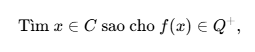

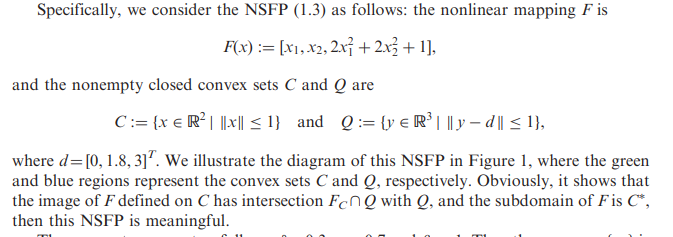

# Implement

In [2]:
from scipy.optimize import Bounds
from autograd import grad
import autograd.numpy as np  
from autograd import jacobian
from project import Projection
from algorithm_CQ import CQ_split_acceptance
from problem import Problem

## Config

In [13]:
def f(x):
    return np.array([
        x[0], 
        x[1], 
        2 * x[0]**2 + 2 * x[1]**2 + 1
    ])

# 2. MIỀN C (Hình tròn đơn vị)
def c1(x):
    return np.linalg.norm(x) - 1

# 3. MIỀN Q
d_vec = np.array([0.0, 1.8, 3.0])
def q1(y):
    return np.linalg.norm(y - d_vec) - 1

def q1_dx(y):
    return np.ones_like(y) 


In [14]:
c1_dx = grad(c1)
# q1_dx = grad(q1)

In [15]:
def q_plus_jac(z):

    grad = np.where(z > 0, -1.0, 0.0)
    return np.array([grad])

In [16]:
cons_C = (
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([-c1(x)]),     
#         'jac' : lambda x: np.array([-c1_dx(x)])   
    },
)


bounds_x = None
dim_x = 2

In [17]:
cons_Q = (
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([-q1(x)]),     
#         'jac' : lambda x: np.array([-q1_dx(x)])   
    },
)

bounds_f = None
dim_y = 3

In [18]:
cons_Qplus = (
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([q_plus_val(x)]),
        'jac' : lambda x: np.array([q_plus_jac(x)])
    },
)

In [20]:
proj_C = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')

proj_Qplus = Projection(cons=cons_Q, bounds=bounds_f, dim=dim_y, proj_type='qplus')

prob = Problem(
    f=[f],
    jac_f=[jacobian(f)],
    C=[c1],
    Q=[q1],
    dim_x=dim_x,
    dim_y=dim_y,
    proj_C=proj_C.project,
    proj_Qplus=proj_Qplus.project
    
)

In [21]:
x0 = np.random.rand(1,dim_x).tolist()
x0 = [[1, 2]]

## Run

In [22]:
x_opt, x_hist, f_hist, z_proj_hist = CQ_split_acceptance(
                                f=prob.objective_func,
                                jac_f=prob.jacobian,
                                proj_C=prob.proj_C,
                                proj_Qplus=prob.proj_Qplus,
                                x0=x0,
                                gamma=0.05,
                                max_iter=100,
                                tol=1e-10
                            )

Khởi tạo: x0: [[1, 2]]
Chiếu lên C được: x: [0.4472 0.8944]


  0%|          | 0/100 [00:00<?, ?it/s]


Hội tụ tại vòng lặp 0
+---+----------------------+---------+--------------------------------+--------------------------------+----------+----------+
| k | x_new                | gamma_k | y                              | z_proj                         |   e_x    |   e_f    |
+---+----------------------+---------+--------------------------------+--------------------------------+----------+----------+
| 0 | [0.447214, 0.894427] | 0.0500  | [0.447214, 0.894427, 3.      ] | [0.447214, 0.894427, 3.      ] | 0.000000 | 0.000000 |
+---+----------------------+---------+--------------------------------+--------------------------------+----------+----------+


# Viz

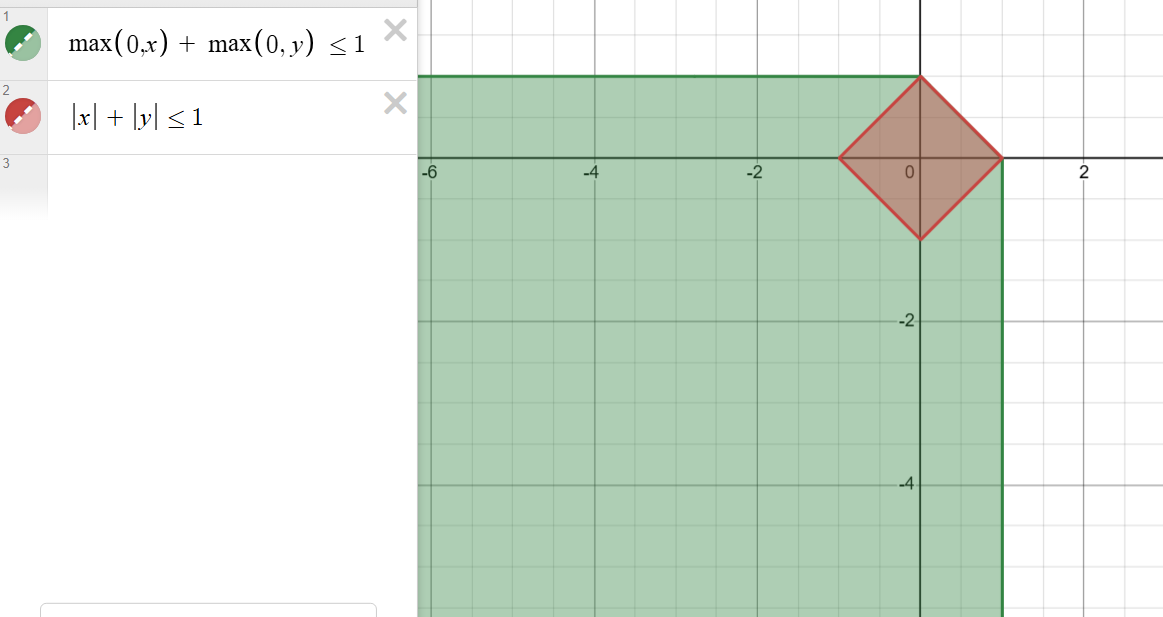

In [37]:
from utils import visualize_complete_system

Đang xử lý dữ liệu và tạo đồ thị tổng hợp...


IndexError: index -1 is out of bounds for axis 0 with size 0

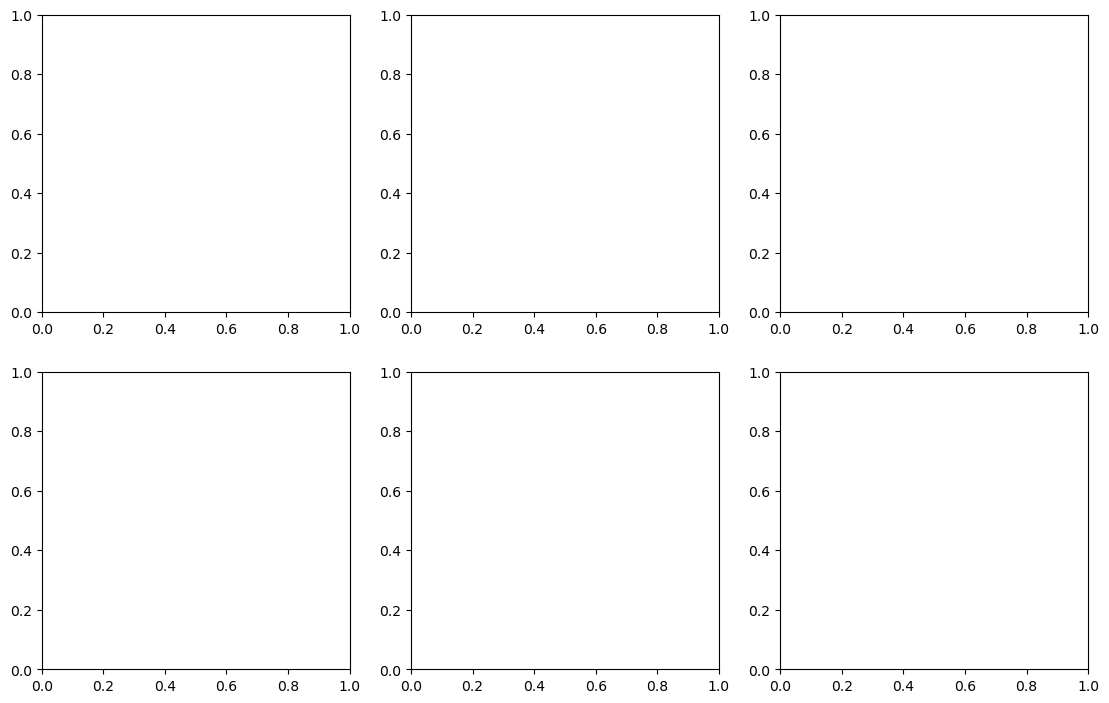

In [38]:
_ = visualize_complete_system(
    x_hist, f_hist, z_proj_hist,
    cons_C, cons_Qplus,
    x0=x0[0],   
)


# Vẽ lại luồng thuật toán

<font size=5>Tìm $x\in C$ sao cho $\exists y \in Q$ thỏa mãn $f(x) \leq y \quad(1)$ 

trong đó: 
* $C, Q$ là tập lồi, đóng
* $f$ là ánh xạ lồi

---

Định nghĩa: 

<font size=4> $Q^+ = \{z \in R^m | \exists y \in Q, z \leq y\}$

Khi đó:

<font size=4> $ (1) \Leftrightarrow $ Tìm $x \in C$ sao cho $f(x) \in Q^+$

---

Hàm khoảng cách:

$ \Phi(x) := \frac{1}{2} \rVert f(x) - P_{Q^+}(f(x)\rVert^2  $

Mục tiêu: đưa $f(x)$ về gần với hình chiếu của nó trên tập $Q^+$ nhất

* $\Phi(x) = 0 \rightarrow x$ là nghiệm chấp nhận tách
* $\Phi(x) \neq 0 \rightarrow $ chuyển về bài toán xấp xỉ tốt nhất

---


<font size=5> $\nabla \Phi (x) = J_f(x)^T (I - P_{Q^+})f(x)$

Công thức cập nhật $x^k$

<font size=5> $\Rightarrow x^{k+1} = P_C(x^k - \gamma_k \nabla\Phi(x^k))$ 

---

$P_C(\tilde x) = \text{Argmin}_{x \in C} \rVert x - \tilde x \rVert ^2$

---

$y^* = \text{Argmin}_{y \in Q} \rVert (y - \tilde z )_+\rVert ^2$

$P_{Q^+}(\tilde z) = \text{min}(\tilde z, y^*) = \tilde z - (\tilde z - y^*)_+$